# Optical Character Recognition (OCR)

OpenGateLLM provides an OCR endpoint based on the Mistral API convention, `/v1/ocr`. For more information on the Mistral API convention, please refer to their [documentation](https://docs.mistral.ai/api/endpoint/ocr).

For the following tutorial, we use [DINUM](https://www.numerique.gouv.fr/) instance of OpenGateLLM, called [Albert API](https://albert.api.etalab.gouv.fr/swagger). If your are not a user of this instance, please refer to the [OpenGateLLM readme](https://github.com/etalab-ia/OpenGateLLM?tab=readme-ov-file#-tutorials--guides) to install and configure your own instance. You need to have a image-to-text model to run this tutorial.


In [ ]:
%pip install -qU mistralai requests datasets pillow

import base64
import os
from urllib.parse import urljoin

from IPython.display import Image, display
from mistralai import Mistral
import requests

First, setup your API key and server URL. You can set the `ALBERT_API_KEY` environment variable or provide it directly, then initialize the Mistral client and a requests session.

In [ ]:
server_url = "https://albert.api.etalab.gouv.fr"
api_key = os.getenv("ALBERT_API_KEY")

session = requests.Session()
session.headers.update({"Authorization": f"Bearer {api_key}"})
client = Mistral(server_url=server_url, api_key=api_key)

Find a audio model with `/v1/models` endpoint to perform OCR. Theses models have the type `image-to-text`.

In [3]:
response = session.get(url=urljoin(server_url, "/v1/models"))
assert response.status_code == 200
models = response.json()["data"]


model = [model for model in models if model["type"] == "image-to-text"][0]["id"]
print(f"OCR model found: {model}")

OCR model found: mistral-ocr-2505


## OCR your PDF Documents

### OCR with a PDF URL

### With Mistral client

Page 0 - markdown:

# The magic of Prince 

Prince is a computer program that converts XML and HTML into PDF. It is simple, yet very powerful, and it creates beautiful documents. The purpose of this small document is to 
[...]

Page 0 - image 0 (box: 429, 1790, 777, 1949)


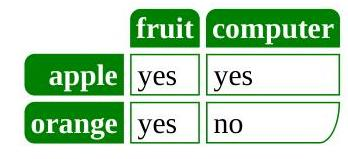

In [13]:
url = "https://www.princexml.com/samples/magic6/magic.pdf"
response = client.ocr.process(model=model, document={"type": "document_url", "document_url": url}, include_image_base64=True)

print(f"Page 0 - markdown:\n\n{response.pages[0].markdown[:200]}\n[...]\n")
print(
    f"Page 0 - image 0 (box: {response.pages[0].images[0].top_left_x}, {response.pages[0].images[0].top_left_y}, {response.pages[0].images[0].bottom_right_x}, {response.pages[0].images[0].bottom_right_y})"
)
display(Image(data=base64.b64decode(response.pages[0].images[0].image_base64.split(",")[1])))

### With requests

Page 0 - markdown:

# The magic of Prince 

Prince is a computer program that converts XML and HTML into PDF. It is simple, yet very powerful, and it creates beautiful documents. The purpose of this small document is to 
[...]

Page 0 - image 0 (box: 433, 1790, 777, 1949)


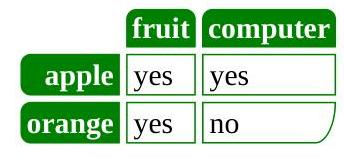

In [14]:
url = "https://www.princexml.com/samples/magic6/magic.pdf"
response = requests.post(
    url=f"{server_url}/v1/ocr",
    headers={"Authorization": f"Bearer {api_key}"},
    json={"model": model, "document": {"type": "document_url", "document_url": url}, "include_image_base64": True},
)
response = response.json()

print(f"Page 0 - markdown:\n\n{response["pages"][0]["markdown"][:200]}\n[...]\n")
print(
    f"Page 0 - image 0 (box: {response["pages"][0]["images"][0]["top_left_x"]}, {response["pages"][0]["images"][0]["top_left_y"]}, {response["pages"][0]["images"][0]["bottom_right_x"]}, {response["pages"][0]["images"][0]["bottom_right_y"]})"
)
display(Image(data=base64.b64decode(response["pages"][0]["images"][0]["image_base64"].split(",")[1])))

### OCR with a base64 encoded PDF

### With Mistral client

Downloaded PDF (135171 bytes) and encoded to base64

Page 0 - markdown:

# Anatomy of the Somatosensory System 

From WIKIbOOKs ${ }^{1}$

Our somatosensory system consists of sensors in the skin and sensors in our muscles, tendons, and joints. The receptors in the skin, t
[...]

Page 0 - image 0 (box: 143, 1075, 965, 1705)


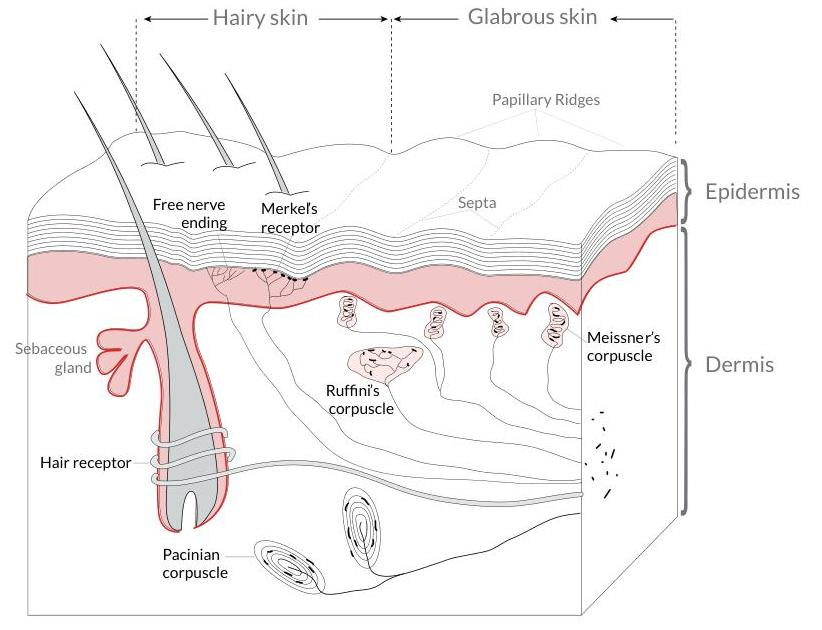

In [ ]:
# Download the PDF and encode it to base64
pdf_url = "https://www.princexml.com/samples/textbook/somatosensory.pdf"
pdf_response = requests.get(pdf_url)
pdf_response.raise_for_status()
pdf_base64 = base64.b64encode(pdf_response.content).decode("utf-8")
print(f"Downloaded PDF ({len(pdf_response.content)} bytes) and encoded to base64")

# Process OCR
response = client.ocr.process(
    model=model, document={"type": "document_url", "document_url": f"data:application/pdf;base64,{pdf_base64}"}, include_image_base64=True
)

print(f"\nPage 0 - markdown:\n\n{response.pages[0].markdown[:200]}\n[...]\n")
if response.pages[0].images:
    print(
        f"Page 0 - image 0 (box: {response.pages[0].images[0].top_left_x}, {response.pages[0].images[0].top_left_y}, {response.pages[0].images[0].bottom_right_x}, {response.pages[0].images[0].bottom_right_y})"
    )
    display(Image(data=base64.b64decode(response.pages[0].images[0].image_base64.split(",")[1])))

### With requests

Page 0 - markdown:

# Anatomy of the Somatosensory System 

From WIKIbOOKs ${ }^{1}$

Our somatosensory system consists of sensors in the skin and sensors in our muscles, tendons, and joints. The receptors in the skin, t
[...]

Page 0 - image 0 (box: 143, 1075, 965, 1705)


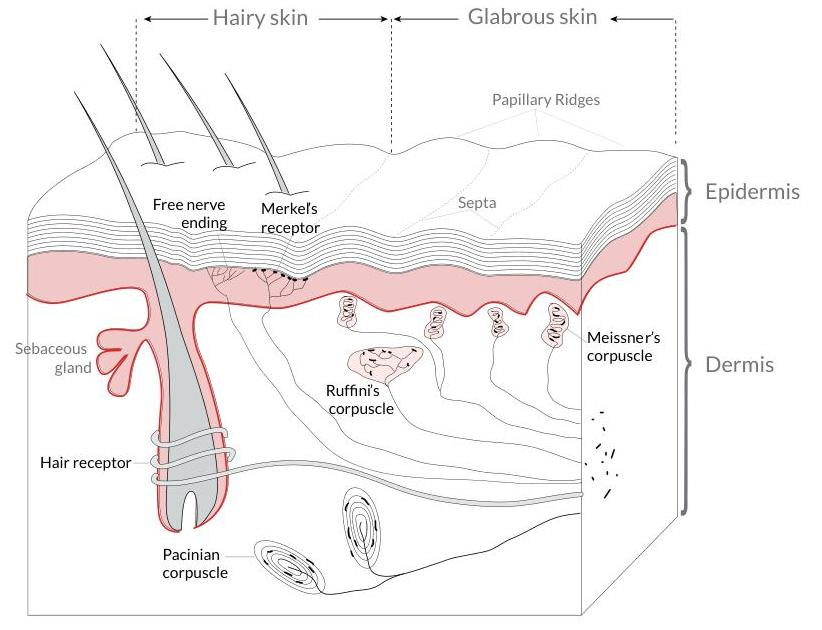

In [7]:
# Option 2 - with requests
response = requests.post(
    url=f"{server_url}/v1/ocr",
    headers={"Authorization": f"Bearer {api_key}"},
    json={
        "model": model,
        "document": {"type": "document_url", "document_url": f"data:application/pdf;base64,{pdf_base64}"},
        "include_image_base64": True,
    },
)
response = response.json()

print(f"Page 0 - markdown:\n\n{response["pages"][0]["markdown"][:200]}\n[...]\n")
if response["pages"][0].get("images"):
    print(
        f"Page 0 - image 0 (box: {response["pages"][0]["images"][0]["top_left_x"]}, {response["pages"][0]["images"][0]["top_left_y"]}, {response["pages"][0]["images"][0]["bottom_right_x"]}, {response["pages"][0]["images"][0]["bottom_right_y"]})"
    )
    display(Image(data=base64.b64decode(response["pages"][0]["images"][0]["image_base64"].split(",")[1])))

## OCR your images

### OCR with a image URL

### With Mistral client

In [8]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/ReceiptSwiss.jpg/1280px-ReceiptSwiss.jpg"

response = client.ocr.process(model=model, document={"type": "image_url", "image_url": image_url}, include_image_base64=True)

print(f"Markdown:\n\n{response.pages[0].markdown[:200]}\n[...]\n")

Markdown:

Berghotel
Grosse Scheidegg
3818 Grindelwald
Familie R.Müller

Rech. Nr. 4572 30.07.2007/13:29:17
Bar Tisch 7/01

2xLatte Macchiato à 4.50 CHF 9.00
1xGloki à 5.00 CHF 5.00
1xSchweinschnitzel à 22.00 CH
[...]



### With requests

In [9]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/ReceiptSwiss.jpg/1280px-ReceiptSwiss.jpg"
response = requests.post(
    url=f"{server_url}/v1/ocr",
    headers={"Authorization": f"Bearer {api_key}"},
    json={"model": model, "document": {"type": "image_url", "image_url": image_url}, "include_image_base64": True},
)
response = response.json()

print(f"Markdown:\n\n{response["pages"][0]["markdown"][:200]}\n[...]\n")

Markdown:

Berghotel
Grosse Scheidegg
3818 Grindelwald
Familie R.Müller

Rech. Nr. 4572 30.07.2007/13:29:17
Bar Tisch 7/01

2xLatte Macchiato à 4.50 CHF 9.00
1xGloki à 5.00 CHF 5.00
1xSchweinschnitzel à 22.00 CH
[...]



### OCR with a base64 encoded image

### With Mistral client

In [10]:
# Download an image and encode it to base64
image_url = "https://ocr.space/Content/Images/receipt-ocr-original.webp"
image_response = requests.get(image_url)
image_response.raise_for_status()

# Encode image bytes directly to base64 (no PIL needed)
image_base64 = base64.b64encode(image_response.content).decode("utf-8")
print(f"Downloaded image and encoded to base64 ({len(image_base64)} characters)")

# Process OCR
response = client.ocr.process(model=model, document={"type": "image_url", "image_url": image_url}, include_image_base64=True)

print(f"\nMarkdown:\n\n{response.pages[0].markdown[:200]}\n[...]\n")
if response.pages[0].images:
    print(
        f"Image 0 (box: {response.pages[0].images[0].top_left_x}, {response.pages[0].images[0].top_left_y}, {response.pages[0].images[0].bottom_right_x}, {response.pages[0].images[0].bottom_right_y})"
    )
    display(Image(data=base64.b64decode(response.pages[0].images[0].image_base64.split(",")[1])))

Downloaded image and encoded to base64 (151020 characters)

Markdown:

# Walmart
Save money. Live better.
(330) 339 - 3991
MANAGER DIANA EARNEST
231 BLUEBELL DR SW
NEW PHILADELPHIA OH 44663
ST# 02115 OP# 009044 TE# 44 TR# 01301
PET TOY 004747571658 1.97 X
FLOPPY PUPPY 00
[...]



### With request

In [ ]:
# Download an image and encode it to base64
image_url = "https://ocr.space/Content/Images/receipt-ocr-original.webp"
image_response = requests.get(image_url)
image_response.raise_for_status()

# Encode image bytes directly to base64 (no PIL needed)
image_base64 = base64.b64encode(image_response.content).decode("utf-8")
print(f"Downloaded image and encoded to base64 ({len(image_base64)} characters)")

# Process OCR
response = requests.post(
    url=f"{server_url}/v1/ocr",
    headers={"Authorization": f"Bearer {api_key}"},
    json={"model": model, "document": {"type": "image_url", "image_url": image_url}, "include_image_base64": True},
)
response = response.json()

print(f"\nMarkdown:\n\n{response["pages"][0]["markdown"][:200]}\n[...]\n")

Downloaded image and encoded to base64 (151020 characters)

Markdown:

# Walmart
Save money. Live better.
(330) 339 - 3991
MANAGER DIANA EARNEST
231 BLUEBELL DR SW
NEW PHILADELPHIA OH 44663
ST# 02115 OP# 009044 TE# 44 TR# 01301
PET TOY 004747571658 1.97 X
FLOPPY PUPPY 00
[...]

